In [1]:
from utils.data_acquisition import get_players, get_matches, get_players_perfomance, get_next_match

## Generating player list ranked by position

In [2]:
players = get_players()

In [3]:
positions = players['position'].unique()

In [4]:
players_ranked = players.copy() 
players_ranked['rank'] = None

for position in positions:
    rank = players_ranked[players_ranked['position'] == position].id.rank(method='min')
    rank = rank - 1
    players_ranked.iloc[rank.index,-1] = rank

columns_sorted = ["rank", "nickname", "id", "position", "price", "team", "status"]
players_ranked = players_ranked[columns_sorted].drop_duplicates().sort_values('rank', ignore_index=True)

In [5]:
players_ranked.head(10)

,rank,nickname,id,position,price,team,status
0,0.0,Rafinha,38144,lat,7.00,SAO,Nulo
1,0.0,Hulk,39148,ata,14.58,CAM,Provável
2,0.0,Renato Augusto,38398,mei,5.02,FLU,Nulo
3,0.0,Thiago Silva,37715,zag,10.00,FLU,Nulo
4,0.0,Fábio,37656,gol,8.89,FLU,Provável
5,0.0,Mano Menezes,37281,tec,8.53,FLU,Provável
6,1.0,Cássio,42234,gol,11.40,CRU,Nulo
7,1.0,Marcelo,38402,lat,9.64,FLU,Nulo
8,1.0,Nenê,38913,mei,4.60,JUV,Provável
9,1.0,Osvaldo,42222,ata,4.29,VIT,Contundido


## Matches

In [6]:
matches = get_matches()

In [7]:
matches["home_score_norm"] = matches["home_score"]/matches["home_score"].max()
matches["away_score_norm"] = matches["away_score"]/matches["away_score"].max()

In [8]:
matches.shape

(130, 8)

In [9]:
matches.head()

,date,home_team,away_team,home_score,away_score,round,home_score_norm,away_score_norm
0,2024-04-13 18:30:00,INT,BAH,2.0,1.0,1,0.4,0.166667
1,2024-04-13 18:30:00,CRI,JUV,1.0,1.0,1,0.2,0.166667
2,2024-04-13 21:00:00,FLU,BGT,2.0,2.0,1,0.4,0.333333
3,2024-04-13 21:00:00,SAO,FOR,1.0,2.0,1,0.2,0.333333
4,2024-04-14 16:00:00,VAS,GRE,2.0,1.0,1,0.4,0.166667


In [10]:
matches.iloc[-1]

date               2024-07-01 20:00:00
home_team                          PAL
away_team                          COR
home_score                         2.0
away_score                         0.0
round                               13
home_score_norm                    0.4
away_score_norm                    0.0
Name: 129, dtype: object

Remark: RS teams didn't player last rounds

In [11]:
matches = matches.dropna().reset_index()

In [12]:
matches.shape

(125, 9)

### Players performance

In [13]:
players_performance = get_players_perfomance()

In [14]:
players_performance = players_performance.drop(
    ["price", "nickname", "position", "team"], axis=1)

In [15]:
players_performance.head()

,id,points,round
0,100079,2.6,1
1,100084,1.4,1
2,100085,5.0,1
3,100652,1.3,1
4,100846,-1.5,1


Joining the above table with the players table, which contains the ranks

In [16]:
players_performance = players_performance.set_index("id").join(players_ranked.set_index("id"))

In [17]:
players_performance.head()

,points,round,rank,nickname,position,price,team,status
id,,,,,,,,
100079,2.6,1,94.0,Zaracho,mei,7.55,CAM,Nulo
100084,1.4,1,95.0,Igor Gomes,mei,5.29,CAM,Provável
100085,5.0,1,96.0,Pedro Augusto,mei,3.87,FOR,Provável
100652,1.3,1,70.0,Yuri Alberto,ata,7.85,COR,Provável
100846,-1.5,1,48.0,Lucas Esteves,lat,3.03,VIT,Provável


**Remark**: The price column here can lead to confusion. This price was get from the market database. So, it is the current price of the player in the market.
For this reason, I will rename the column: 

In [18]:
players_performance = players_performance.rename(columns={"price": "current_price"})

In [19]:
players_performance.columns

Index(['points', 'round', 'rank', 'nickname', 'position', 'current_price',
       'team', 'status'],
      dtype='object')

In [20]:
players_performance.shape

(4057, 8)

Removing player that are not available in the market

In [21]:
players_performance.drop(
    players_performance[players_performance['rank'].isnull()].index,
    inplace=True)

players_performance['rank'] = players_performance['rank'].astype(int)

In [22]:
players_performance.head()

,points,round,rank,nickname,position,current_price,team,status
id,,,,,,,,
100079,2.6,1,94,Zaracho,mei,7.55,CAM,Nulo
100084,1.4,1,95,Igor Gomes,mei,5.29,CAM,Provável
100085,5.0,1,96,Pedro Augusto,mei,3.87,FOR,Provável
100652,1.3,1,70,Yuri Alberto,ata,7.85,COR,Provável
100846,-1.5,1,48,Lucas Esteves,lat,3.03,VIT,Provável


In [23]:
players_performance.shape

(3934, 8)

## Transition matrix M between the states
Until here, it is not clear for me yet what the states in this matrix means

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from typing import Literal, Callable, Tuple
from numpy._typing import NDArray, ArrayLike

In [25]:
def normalize_transition_matrix(m: NDArray) -> NDArray:
    """."""
    M_norm = m.copy()
    M_norm = M_norm / np.sum(M_norm, axis=1)[:, None] # Normalizing the rows.
    M_norm = np.nan_to_num(M_norm, nan=1/M_norm.shape[0])  # Replacing no info rows with equally distributed probability
    return M_norm

In [26]:
def forward(home_goals: int, away_goals: int) -> Tuple[int, int]:
    return home_goals, away_goals

def defender(home_goals: int, away_goals: int):
    home_extra_score, away_extra_score = 1, 1
    if away_goals:
        home_extra_score =- 1
    if home_goals:
        away_extra_score = -1
    return home_extra_score, away_extra_score

def midfilder(home_goals: int, away_goals: int) -> Tuple[int, int]:
    forward_h, forward_a = forward(home_goals, away_goals)
    defender_h, defender_a = defender(home_goals, away_goals)
    return forward_h + defender_h, forward_a + defender_a

def manager(*args) -> Tuple[int, int]:
    return 0,0

In [27]:
def generate_m_matrix(
        position: Literal["ata", "mei", "zag", "tec"], 
        extra_function: Callable[[int, int], Tuple[int, int]]
) -> NDArray:
    """."""
    players_performance_position = players_performance[
        players_performance["position"] == position
        ].copy()

    n_players = len(players_ranked[players_ranked["position"] == position])
    M = np.zeros([n_players, n_players])

    # The match are labeled from 0 to len(matches)
    for match in range(len(matches)):
        # Selecting all players that played in the round where the match ocurred
        df_round = players_performance_position[
            players_performance_position["round"] == matches["round"][match]
        ]
        # Selecting the players that played in the given match
        players_home = df_round[df_round["team"] == matches["home_team"][match]]
        players_away = df_round[df_round["team"] == matches["away_team"][match]]

        for p_home in range(len(players_home)):
            for p_away in range(len(players_away)):
                score_home, score_away = 0,0
            
                points_p_home = players_home["points"].iloc[p_home]
                points_p_away = players_away["points"].iloc[p_away]

                sum = points_p_home + points_p_away
                if sum != 0:
                    score_home = points_p_home/sum
                    score_away = points_p_away/sum
                
                # Selecting the coordinates of each player in the matrix
                p1 = players_home["rank"].iloc[p_home]
                p2 = players_away["rank"].iloc[p_away]

                home_extra_score, away_extra_score = extra_function(
                    matches['home_score_norm'][match],
                    matches['away_score_norm'][match]
                )
                home_extra_score, away_extra_score = 0,0

                M[p1,p1] = M[p1,p1] + home_extra_score + score_home
                M[p1,p2] = M[p1,p2] + away_extra_score + score_away
                M[p2,p1] = M[p2,p1] + home_extra_score + score_home
                M[p2,p2] = M[p2,p2] + away_extra_score + score_away
    
    # return normalize_transition_matrix(M)
    return M


In [28]:
def stacionary_distribution(m_norm: NDArray) -> ArrayLike:
    """."""
    tolerances = [1e-10, 1e-4, 1e-3, 1e-2]
    evals, evecs = np.linalg.eig(m_norm.T)
    
    for tol in tolerances:
        try: # TODO: Change this to a size validation
            # evec1 = evecs[:,np.isclose(evals, 1, rtol=0, atol=tol)] # Increase the tolerance a little
            evec1 = evecs[:,np.isclose(evals, 1, rtol=0, atol=tol)] # Increase the tolerance a little
            evec1 = evec1[:,0]
        except:
            print(f"tolerance: {tol} didn't work")
            continue
        stationary = evec1 / evec1.sum()
        stationary = stationary.real
        return stationary, evals, evecs

In [29]:
out_data = {
    "gol": {"func": defender},
    "zag": {"func": defender},
    "lat": {"func": defender},
    "mei": {"func": midfilder},
    "ata": {"func": forward},
    "tec": {"func": manager}
}

In [30]:
for position, content in out_data.items():
    content['M'] = generate_m_matrix(position, content["func"])
    content['M_norm'] = normalize_transition_matrix(content['M'])
    content["st_dist"], *_ = stacionary_distribution(content['M_norm'])

/tmp/ipykernel_12074/3863926212.py:4: RuntimeWarning: invalid value encountered in divide
  M_norm = M_norm / np.sum(M_norm, axis=1)[:, None] # Normalizing the rows.


Transiction matrix plot

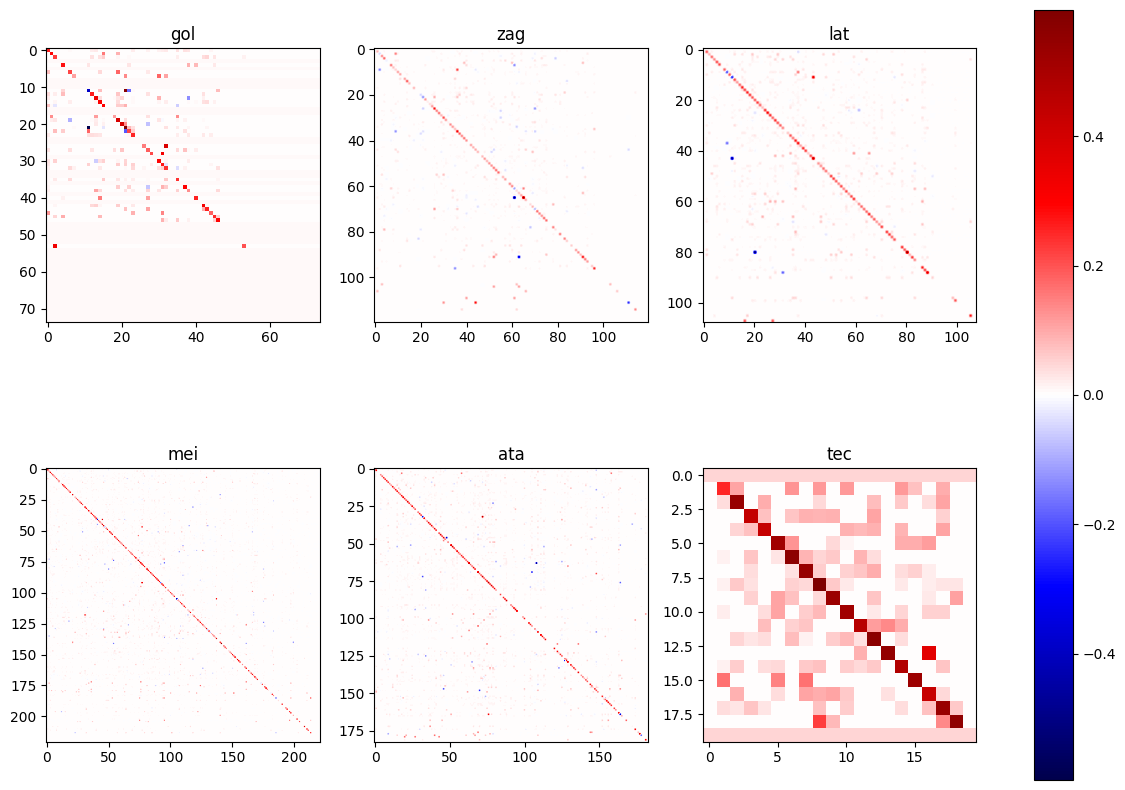

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axesli = axes.flatten()
for i, key in enumerate(out_data):
    im = axesli[i].imshow(out_data[key]["M_norm"], cmap='seismic', norm=TwoSlopeNorm(0))
    axesli[i].set_title(key)

fig.colorbar(im, ax=axes.ravel())


Stationary Distribution plot 

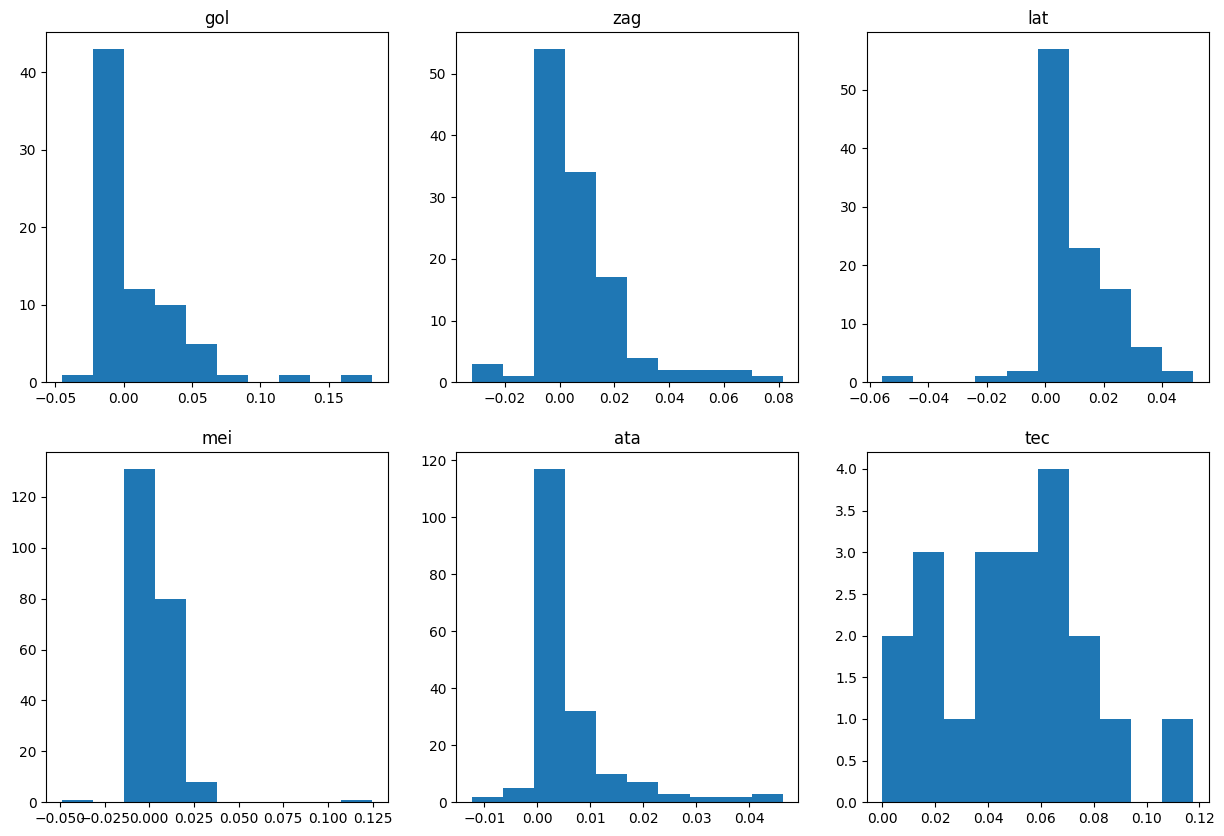

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axesli = axes.flatten()
for i, key in enumerate(out_data):
    im = axesli[i].hist(out_data[key]["st_dist"])
    axesli[i].set_title(key)

### Overperfomance players for each position

In [33]:
position = 'gol'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
4,0.0,Fábio,37656,gol,8.89,FLU,Provável
16,2.0,Walter,51413,gol,5.40,CUI,Provável
82,13.0,Gabriel,70449,gol,3.63,JUV,Provável
89,14.0,Weverton,71631,gol,11.76,PAL,Provável
93,15.0,Everson,72294,gol,8.14,CAM,Nulo


In [34]:
position = 'zag'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)]

,rank,nickname,id,position,price,team,status
23,3.0,Titi,50353,zag,4.33,FOR,Provável
24,4.0,David Luiz,52827,zag,6.74,FLA,Provável
64,10.0,Maicon,71227,zag,4.01,VAS,Provável
85,14.0,Mercado,72951,zag,5.96,INT,Nulo
151,26.0,Léo Pereira,83528,zag,6.54,FLA,Nulo
170,30.0,Rodrigo,86684,zag,5.11,CRI,Provável
178,31.0,Pedro Henrique,87225,zag,5.94,BGT,Provável
201,36.0,Fabrício Bruno,90768,zag,6.20,FLA,Provável
206,37.0,Zé Marcos,90943,zag,3.36,JUV,Provável
215,39.0,Rodrigo Sam,91509,zag,4.68,JUV,Nulo


In [35]:
position = 'lat'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > 0)].head()

,rank,nickname,id,position,price,team,status
0,0.0,Rafinha,38144,lat,7.00,SAO,Nulo
7,1.0,Marcelo,38402,lat,9.64,FLU,Nulo
14,2.0,Mariano,38877,lat,4.87,CAM,Provável
21,3.0,Fagner,42500,lat,6.97,COR,Contundido
26,4.0,Cicinho,61106,lat,4.42,BAH,Nulo


In [36]:
position = 'mei'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
8,1.0,Nenê,38913,mei,4.60,JUV,Provável
18,3.0,Everton Ribeiro,51772,mei,9.22,BAH,Dúvida
78,13.0,Nikão,69705,mei,8.81,CAP,Contundido
125,21.0,Fernandinho,72775,mei,6.65,CAP,Provável
161,28.0,Jadson,80129,mei,9.13,JUV,Provável


In [37]:
position = 'ata'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
9,1.0,Osvaldo,42222,ata,4.29,VIT,Contundido
56,9.0,Pablo,69138,ata,5.62,CAP,Provável
94,15.0,Everaldo,78117,ata,7.80,BAH,Provável
114,19.0,Luciano,80287,ata,12.43,SAO,Suspenso
130,22.0,Luiz Araújo,82627,ata,9.58,FLA,Provável


In [38]:
position = 'tec'
dist = out_data[position]['st_dist']
deviation = dist.std()
players_ranked[players_ranked.position==position][list(dist > deviation)].head()

,rank,nickname,id,position,price,team,status
17,2.0,Tite,45125,tec,11.05,FLA,Provável
19,3.0,Cláudio Tencati,78450,tec,6.08,CRI,Provável
28,4.0,Roger Machado,79437,tec,6.79,JUV,Provável
33,5.0,Petit,89141,tec,6.39,CUI,Provável
37,6.0,Eduardo Coudet,94853,tec,9.16,INT,Provável


## Using linear programming to build the team

Adding probabilities in players on the market data

In [39]:
df_players_anl = players_ranked.copy()
df_players_anl['rank'] = df_players_anl['rank'].astype(int)
df_players_anl['prob'] = 0.00

In [40]:
def get_prob(df):
    position = df['position']
    rank = df['rank']
    return out_data.get(position)["st_dist"][int(rank)]

In [41]:
df_players_anl['prob'] = df_players_anl.apply(get_prob, axis=1)

In [42]:
df_players_anl.sort_values('prob', ascending=False).head()

,rank,nickname,id,position,price,team,status,prob
129,21,Marcos Felipe,85004,gol,6.43,BAH,Provável,0.182008
390,74,Raphael Veiga,94509,mei,12.62,PAL,Suspenso,0.124959
119,19,João Ricardo,81881,gol,7.99,FOR,Provável,0.118165
48,8,Rogério Ceni,97341,tec,9.40,BAH,Provável,0.117614
74,12,Abel Ferreira,110506,tec,12.42,PAL,Provável,0.088379


Lets remove probs that aren't between -1 and 1.

In [43]:
df_players_anl = df_players_anl[(df_players_anl['prob'] > -1) & (df_players_anl['prob'] < 1)]

In [44]:
df_players_anl['nickname'] = df_players_anl['nickname'].str.replace(" ", "_")
df_players_likely = df_players_anl[df_players_anl.status == "Provável"]

### Giving extra probability points for the players that will play at home.

I found this [study](https://www.scielo.br/j/rbcdh/a/wc9c38CkYs5NZJYSF6SpNJR/?format=pdf&lang=pt) who says that teams in brazillian championship has 25% more chance to win when playing at home;


In [45]:
next_matches = get_next_match()

In [46]:
home_team = next_matches["home_team"].values

In [47]:
home_team

array(['CUI', 'VAS', 'CRI', 'CAM', 'BGT', 'CAP', 'GRE', 'BAH', 'FLU',
       'COR'], dtype=object)

In [48]:
df_players_likely_bonus = df_players_likely.copy()

In [49]:
df_players_likely_bonus.loc[df_players_likely_bonus.team.isin(home_team), 'prob'] *= 1.25

In [50]:
df_players_likely_bonus.head()

,rank,nickname,id,position,price,team,status,prob
1,0,Hulk,39148,ata,14.58,CAM,Provável,6.646480e-03
4,0,Fábio,37656,gol,8.89,FLU,Provável,4.863117e-02
5,0,Mano_Menezes,37281,tec,8.53,FLU,Provável,5.300275e-18
8,1,Nenê,38913,mei,4.60,JUV,Provável,1.403099e-02
10,1,Thiago_Heleno,38394,zag,5.82,CAP,Provável,1.437255e-02


### Optimization

In [51]:
from pulp import LpMaximize, LpProblem, lpSum, LpVariable
from itertools import product as  cartersian_product
import pandas as pd

In [52]:
# Team and money constraints
team = {
    'ata': 3,
    'mei': 3,
    'lat': 2,
    'zag': 2,
    'gol':1,
    'tec':1
}

money = 105.46

In [53]:
# Selecting the dataframe to use in the optimization
df = df_players_likely_bonus.copy()

In [54]:
df.set_index("id", inplace=True)
df.head()

,rank,nickname,position,price,team,status,prob
id,,,,,,,
39148,0,Hulk,ata,14.58,CAM,Provável,6.646480e-03
37656,0,Fábio,gol,8.89,FLU,Provável,4.863117e-02
37281,0,Mano_Menezes,tec,8.53,FLU,Provável,5.300275e-18
38913,1,Nenê,mei,4.60,JUV,Provável,1.403099e-02
38394,1,Thiago_Heleno,zag,5.82,CAP,Provável,1.437255e-02


In [55]:
sorted = df.sort_values(by=['prob'], axis=0, ascending=False)
sorted[sorted.position == "ata"]

,rank,nickname,position,price,team,status,prob
id,,,,,,,
117909,129,Wesley,ata,6.91,COR,Provável,0.057906
101960,76,Vitinho,ata,9.53,BGT,Provável,0.053391
112886,111,Lucas_Barbosa,ata,9.89,JUV,Provável,0.044005
82627,22,Luiz_Araújo,ata,9.58,FLA,Provável,0.037971
99818,69,Paulinho,ata,12.87,CAM,Provável,0.035843
105811,88,Wesley,ata,10.93,INT,Provável,0.032753
102598,78,Helinho,ata,9.74,BGT,Provável,0.027477
128915,163,Estêvão,ata,6.65,PAL,Provável,0.025732
101002,72,Júnior_Santos,ata,7.90,BOT,Provável,0.020442


In [56]:
all_conflicts = []
# Computing all combinations of players that will  play against
for _, row in next_matches.iterrows(): # We just have 9 lines, it is not too bad use iterrows here
    home_team, away_team = row['home_team'], row['away_team']
    players_home = df[df['team'] == home_team].index.values
    players_away = df[df['team'] == away_team].index.values
    all_conflicts += list(cartersian_product(players_home, players_away))

In [57]:
len(all_conflicts)

1267

In [58]:
z = df['prob'].to_dict()
c = df['price'].to_dict()

dummies_position = pd.get_dummies(df.position)
dummies_position = dummies_position.to_dict()
prob = LpProblem("Players CHoice", LpMaximize)
y = LpVariable.dicts("player_id", df.index , 0,1, cat='Binary')
prob += lpSum([z[i] * y[i] for i in y])

/home/jucelio/.local/share/virtualenvs/mkv-cartola-AYh-Mpys/lib/python3.9/site-packages/pulp/pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [59]:
prob += lpSum([c[i] * y[i] for i in y]) <= money, "money_limit"
prob += lpSum([dummies_position['ata'][i] * y[i] for i in y]) == team['ata'], "Quantidade Atacantes"
prob += lpSum([dummies_position['lat'][i] * y[i] for i in y]) == team['lat'], "Quantidade Laterais"
prob += lpSum([dummies_position['mei'][i] * y[i] for i in y]) == team['mei'], "Quantidade Meio"
prob += lpSum([dummies_position['zag'][i] * y[i] for i in y]) == team['zag'], "Quantidade Zagueiros"
prob += lpSum([dummies_position['gol'][i] * y[i] for i in y]) == team['gol'], "Quantidade Gol"
prob += lpSum([dummies_position['tec'][i] * y[i] for i in y]) == team['tec'], "Quantidade Tecnico"

# Add the conflicts rule
for i, j in all_conflicts:
    prob += y[i] + y[j] <= 1

In [60]:
money

105.46

In [61]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/jucelio/.local/share/virtualenvs/mkv-cartola-AYh-Mpys/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/95328b7503d44dc998fe137014745c76-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/95328b7503d44dc998fe137014745c76-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1279 COLUMNS
At line 4939 RHS
At line 6214 BOUNDS
At line 6440 ENDATA
Problem MODEL has 1274 rows, 225 columns and 2984 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.861779 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 subs

1

In [62]:
escalados = []
for v in prob.variables():
    if v.varValue == 1:
        atleta = v.name.replace('player_id_','')
        escalados.append(int(atleta))
        print(atleta, "=", v.varValue)

101960 = 1.0
105373 = 1.0
110668 = 1.0
117632 = 1.0
117909 = 1.0
72775 = 1.0
82627 = 1.0
85004 = 1.0
90768 = 1.0
94968 = 1.0
97341 = 1.0
98022 = 1.0


In [63]:
my_team = df.loc[escalados]

In [64]:
my_team

,rank,nickname,position,price,team,status,prob
id,,,,,,,
101960,76,Vitinho,ata,9.53,BGT,Provável,0.053391
105373,75,Gabriel_Xavier,zag,5.27,BAH,Provável,0.070133
110668,78,Esquivel,lat,9.07,CAP,Provável,0.043870
117632,168,Garro,mei,7.91,COR,Provável,0.035120
117909,129,Wesley,ata,6.91,COR,Provável,0.057906
72775,21,Fernandinho,mei,6.65,CAP,Provável,0.025731
82627,22,Luiz_Araújo,ata,9.58,FLA,Provável,0.037971
85004,21,Marcos_Felipe,gol,6.43,BAH,Provável,0.227510
90768,36,Fabrício_Bruno,zag,6.20,FLA,Provável,0.081454


In [65]:
my_team['price'].sum()

95.92

TODO: 
- ~~Adicionar bonus para o caso do próximo jogo ser em casa;~~
- Adicionar bonus para quem joga contra os últimos da tabela; ou a diferença entre as posições(?)
- ~~Adicionar restrição para que os jogadores escalados não se enfrentem na rodada;~~
- Adicionar minimização para escolher os melhores reservas;
- Adicionar possibilidade de outras escalações;
- Adicionar método para a escolha do capitão.



## Model Results

In [70]:
results = pd.read_csv("results/2024.csv")

In [71]:
results.columns

Index(['Rodada', 'Score', 'Players Mean', 'Money', 'Aditional Info'], dtype='object')

<Axes: title={'center': 'Model Results'}, xlabel='Rodada'>

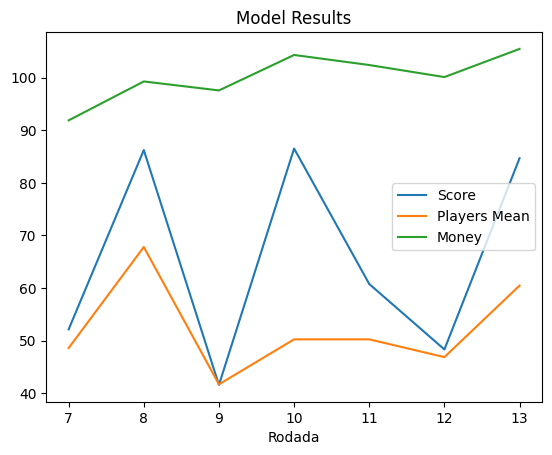

In [72]:
results.plot(x='Rodada', y=['Score', 'Players Mean', "Money"], title='Model Results')